![image.png](attachment:image.png)

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [205]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ipywidgets import interactive

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn import metrics
from scipy.stats import ks_2samp
from scipy.stats import t

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif


In [206]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [207]:
df = pd.read_feather('/content/drive/MyDrive/credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [208]:
# Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.

df['data_ref'].value_counts()

data_ref
2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
Name: count, dtype: int64

In [209]:
# separando as variáveis númericas e categóricas para posterior análise dos dados

variaveis_categoricas = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia', 'mau']
variaveis_numericas = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']

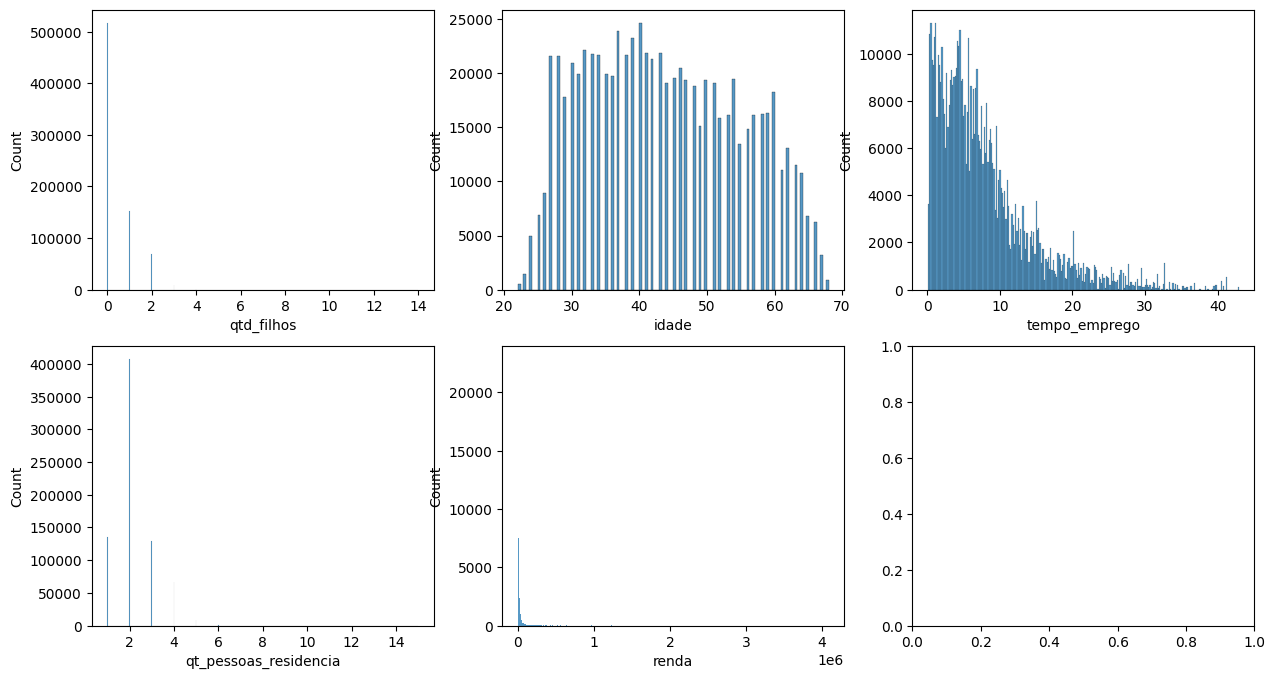

In [210]:
fig, ax = plt.subplots(2, 3, figsize=(15, 8))

i = 0
j = 0

for col in variaveis_numericas:

  sns.histplot(df[col], ax=ax[i, j])

  if j < 2:
    j += 1
  else:
    i += 1
    j = 0


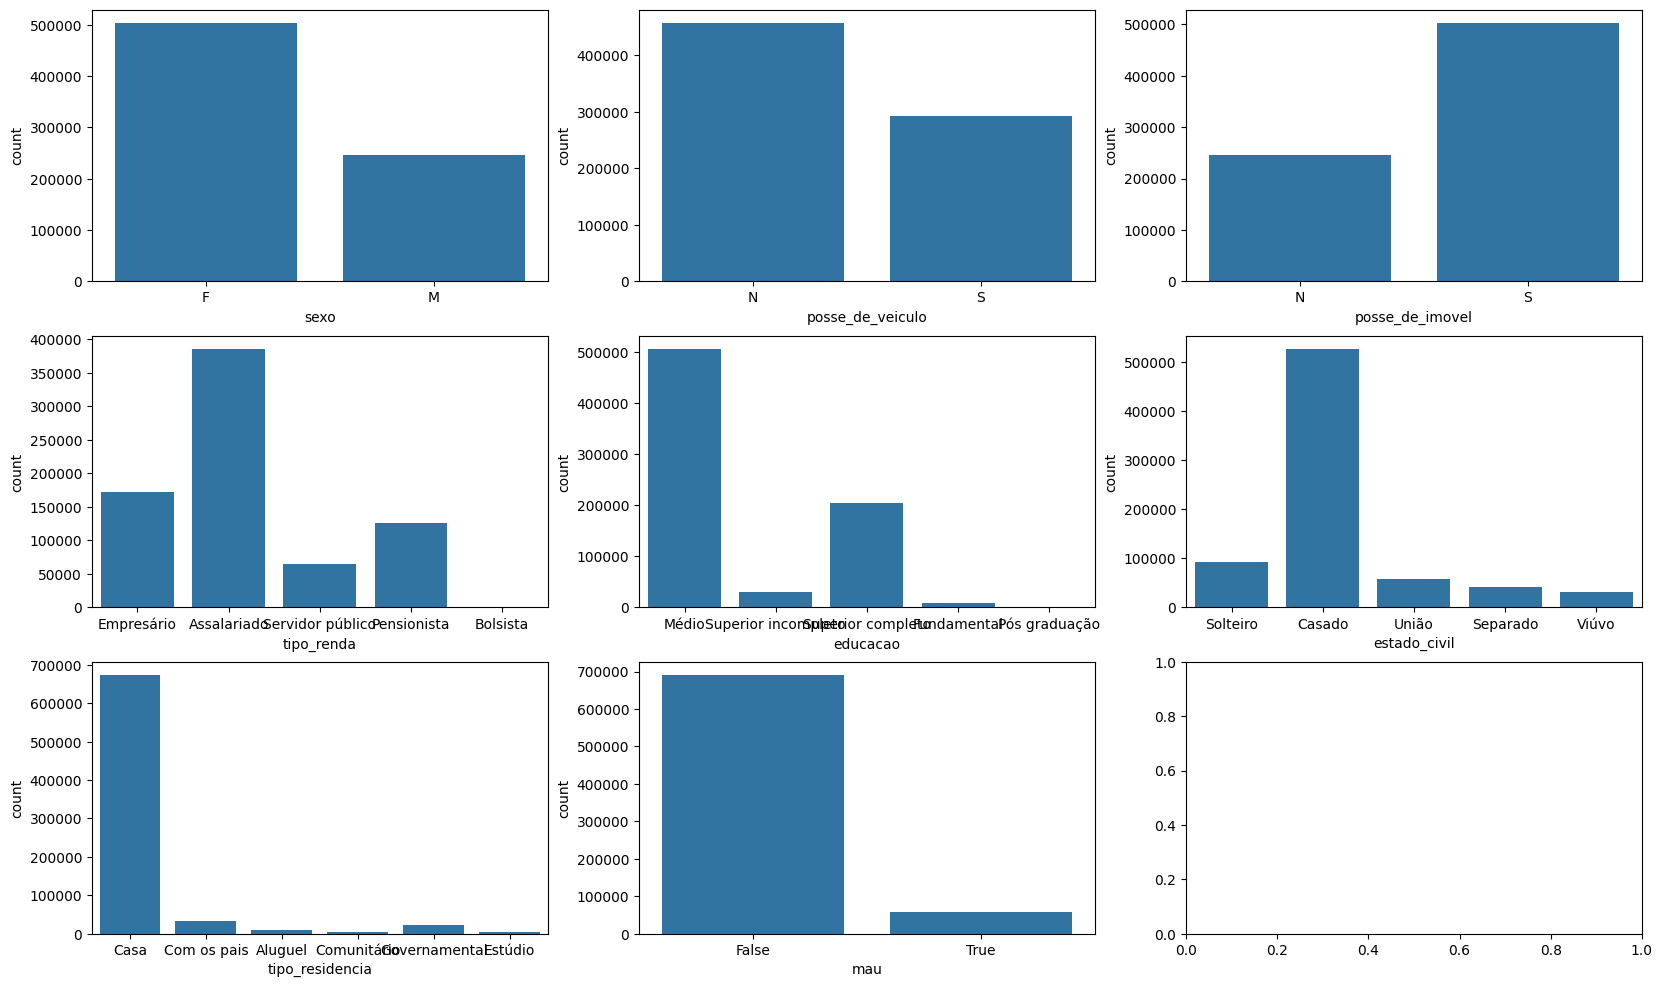

In [211]:
fig, ax = plt.subplots(3, 3, figsize=(20, 12))

i = 0
j = 0

for col in variaveis_categoricas:

  sns.countplot(x=df[col],ax=ax[i, j])

  if j < 2:
    j += 1
  else:
    i += 1
    j = 0

In [212]:
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]

    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

In [213]:
# construindo a base de metadados

metadados = pd.DataFrame(df.dtypes, columns=['dtype'])
metadados['missing'] = df.isna().sum()
metadados['valores_unicos'] = df.nunique()
metadados['papel'] = 'covariavel'
metadados.loc['mau','papel'] = 'resposta'

# calculando o IV de cada variável

for var in metadados[metadados.papel=='covariavel'].index:
    if  (metadados.loc[var, 'valores_unicos']>6):
        metadados.loc[var, 'IV'] = IV(pd.qcut(df[var],5,duplicates='drop'), df.mau)
    else:
        metadados.loc[var, 'IV'] = IV(df[var], df.mau)


metadados

,dtype,missing,valores_unicos,papel,IV
data_ref,datetime64[ns],0,15,covariavel,0.345982
index,int64,0,16650,covariavel,0.002664
sexo,object,0,2,covariavel,0.002185
posse_de_veiculo,object,0,2,covariavel,0.000108
posse_de_imovel,object,0,2,covariavel,0.009693
qtd_filhos,int64,0,8,covariavel,0.000030
tipo_renda,object,0,5,covariavel,0.009360
educacao,object,0,5,covariavel,0.003547
estado_civil,object,0,5,covariavel,0.001126
tipo_residencia,object,0,6,covariavel,0.003045


## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

In [214]:
# análise bivariada das variáveis categóricas


def biv_discreta(var, base):
    df = base.copy()
    df['bom'] = 1-df.mau
    g = df.groupby(var)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(),
                        'cont':g[var].count()})

    biv[var] = g['mau'].mean().index

    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep

    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')

    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)

    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=15)

    ax[1] = biv.cont.plot.bar()

    plt.show()



In [215]:
%matplotlib inline

@interact(var=variaveis_categoricas)
def biv_discreta_inter(var):
  biv_discreta(var, df)

interactive(children=(Dropdown(description='var', options=('sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tip…

*Após análise, a fim de otimidar o desempenho do modelo a ser elaborado, será interessante:*

*   Integrar bolsista ao assalariado
*   categorizar escolaridade por até o médio e pós médio
*   integrar estado civil separado, solteiro, união, e viúvo
*   catgorizar tipo de residência por casa e não casa







In [216]:
# análise bivariada das variáveis numéricas

def biv_continua(var, ncat, base):
    df['bom'] = 1-df.mau
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = df.groupby(cat_srs)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(),
                        var: g[var].mean(),
                        'cont':g[var].count()})

    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep

    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))

    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')

    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)

    ax[1] = biv.cont.plot.bar()
    plt.show()

In [217]:
%matplotlib inline

@interact(var=variaveis_numericas, ncat=(2,10))
def biv_continua_inter(var, ncat):
  biv_continua(var, ncat, df)

interactive(children=(Dropdown(description='var', options=('qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas…

*Após análise, a fim de otimidar o desempenho do modelo a ser elaborado, será interessante:*

*   integrar com ou sem filhos
*   dividir idade em duas categorias
*   dividir tempo de emprego em duas categorias
*   dividir quantidade de pessoas na residencia em duas categorias
*   dividir renda em 4 categorias



## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [218]:
df2 = df.copy()

In [219]:
# agrupamento de categorias

# Integrar bolsista ao assalariado
df2.tipo_renda.replace({'Bolsista':'Assalariado'}, inplace=True)

# caegorizar até o médio e pós médio
df2.educacao.replace({
    'Médio':'Ate_medio',
    'Fundamental': 'Ate_medio',
    'Superior completo': 'Superior',
    'Superior incompleto': 'Superior',
    'Pós graduação': 'Superior',
     }, inplace=True)

# integrar separado, solteiro, união, e viúvo
df2.estado_civil.replace({
    'Solteiro':'Nao_casado',
    'União': 'Nao_casado',
    'Separado': 'Nao_casado',
    'Viúvo': 'Nao_casado',
     }, inplace=True)

# separar em tipos de residência em casa ou não
df2.tipo_residencia.replace({
    'Com os pais':'Nao_casa',
    'Aluguel': 'Nao_casa',
    'Comunitário': 'Nao_casa',
    'Governamental': 'Nao_casa',
    'Estúdio': 'Nao_casa',
     }, inplace=True)



In [220]:
# agrupameno variáveis categóricas

# agrupar tem ou não filhos
df2['tem_filhos'] = df2.qtd_filhos.apply(lambda x: 1 if x > 0 else 0)

# agrupar tem 2 pessoa na residência ou mais
df2['qt_pessoas_residencia_cat'] = df2.qt_pessoas_residencia.apply(lambda x: 'ate_2' if x >= 2 else 'mais_2')

# dividir idade em duas categorias
df2['idade_cat'] = pd.qcut(df['idade'], 2)

# dividir tempo de emprego em duas categorias
df2['tempo_emprego_cat'] = pd.qcut(df['tempo_emprego'], 2)

# dividir renda em 4 categorias
df2['renda_cat'] = pd.qcut(df['renda'], 4)

In [221]:
# Transformar a variável resposta em inteiro
df2['mau'] = df2.mau.astype('int64')

In [222]:
# Separe os três últimos meses como safras de validação *out of time* (oot).

df_treino = df2.loc[df['data_ref'].isin(df2['data_ref'].unique()[:-3])]
df_teste = df2.loc[~df['data_ref'].isin(df2['data_ref'].unique()[:-3])]

In [223]:
# excluindo linhas com missings

df_treino = df_treino.drop(df_treino.loc[df2['tempo_emprego'].isna()].index)
df_teste = df_teste.drop(df_teste.loc[df2['tempo_emprego'].isna()].index)


In [224]:
formula = '''
    mau ~ sexo + posse_de_veiculo + posse_de_imovel + tem_filhos + tipo_renda +
    educacao + estado_civil + tipo_residencia + idade_cat + tempo_emprego_cat +
    renda_cat + qt_pessoas_residencia_cat
    '''

rl = smf.glm(formula, data=df_treino, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               499125
Model:                            GLM   Df Residuals:                   499108
Model Family:                Binomial   Df Model:                           16
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0055e+05
Date:                Sun, 28 Jul 2024   Deviance:                   2.0109e+05
Time:                        02:59:19   Pearson chi2:                 4.99e+05
No. Iterations:                     8   Pseudo R-squ. (CS):            0.05204
Covariance Type:            nonrobust                                         
================================================================================================================================
                                                                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------
Intercept                                                       -1.4322      0.018    -80.768      0.000      -1.467      -1.397
sexo[T.M]                                                       -0.0643      0.014     -4.625      0.000      -0.092      -0.037
posse_de_veiculo[T.S]                                            0.0277      0.013      2.064      0.039       0.001       0.054
posse_de_imovel[T.S]                                            -0.0655      0.013     -5.058      0.000      -0.091      -0.040
tipo_renda[T.Empresário]                                        -0.0239      0.014     -1.690      0.091      -0.052       0.004
tipo_renda[T.Pensionista]                                       -0.0196      0.230     -0.085      0.932      -0.470       0.431
tipo_renda[T.Servidor público]                                  -0.0295      0.023     -1.261      0.207      -0.075       0.016
educacao[T.Superior]                                            -0.0412      0.014     -3.041      0.002      -0.068      -0.015
estado_civil[T.Nao_casado]                                       0.0321      0.018      1.735      0.083      -0.004       0.068
tipo_residencia[T.Nao_casa]                                      0.0191      0.019      1.016      0.310      -0.018       0.056
idade_cat[T.Interval(43.0, 68.0, closed='right')]               -0.0149      0.014     -1.041      0.298      -0.043       0.013
tempo_emprego_cat[T.Interval(6.047, 42.907, closed='right')]    -0.1469      0.015    -10.024      0.000      -0.176      -0.118
renda_cat[T.Interval(3467.7, 7861.82, closed='right')]          -1.0156      0.015    -69.351      0.000      -1.044      -0.987
renda_cat[T.Interval(7861.82, 18318.28, closed='right')]        -1.7398      0.018    -96.763      0.000      -1.775      -1.705
renda_cat[T.Interval(18318.28, 4083986.22, closed='right')]     -2.8818      0.028   -104.182      0.000      -2.936      -2.828
qt_pessoas_residencia_cat[T.mais_2]                             -0.0471      0.024     -1.957      0.050      -0.094    7.19e-05
tem_filhos                                                      -0.0023      0.014     -0.160      0.873      -0.030       0.026
================================================================================================================================
"""

*Verifica-se que as variáveis mais significantes são: sexo, posse de imóvel, educacao, tempo de emprego categórico, renda categórica*

In [225]:
formula = '''
    mau ~ sexo + posse_de_imovel +
    educacao + tempo_emprego_cat +
    renda_cat
    '''

rl = smf.glm(formula, data=df_treino, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               499125
Model:                            GLM   Df Residuals:                   499117
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0055e+05
Date:                Sun, 28 Jul 2024   Deviance:                   2.0111e+05
Time:                        02:59:26   Pearson chi2:                 4.99e+05
No. Iterations:                     8   Pseudo R-squ. (CS):            0.05201
Covariance Type:            nonrobust                                         
================================================================================================================================
                                                                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------
Intercept                                                       -1.4320      0.013   -107.800      0.000      -1.458      -1.406
sexo[T.M]                                                       -0.0524      0.013     -4.042      0.000      -0.078      -0.027
posse_de_imovel[T.S]                                            -0.0693      0.013     -5.501      0.000      -0.094      -0.045
educacao[T.Superior]                                            -0.0396      0.013     -3.011      0.003      -0.065      -0.014
tempo_emprego_cat[T.Interval(6.047, 42.907, closed='right')]    -0.1478      0.015    -10.171      0.000      -0.176      -0.119
renda_cat[T.Interval(3467.7, 7861.82, closed='right')]          -1.0167      0.015    -69.487      0.000      -1.045      -0.988
renda_cat[T.Interval(7861.82, 18318.28, closed='right')]        -1.7419      0.018    -97.038      0.000      -1.777      -1.707
renda_cat[T.Interval(18318.28, 4083986.22, closed='right')]     -2.8870      0.028   -104.828      0.000      -2.941      -2.833
================================================================================================================================
"""

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [226]:
proporcao_mau = df2.mau.value_counts()[1] / df2.mau.value_counts().sum()

In [227]:
df_treino['score'] = rl.predict()

# Acurácia
acc = metrics.accuracy_score(df_treino.mau, df_treino.score > proporcao_mau)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(df_treino.mau, df_treino.score)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(df_treino.loc[df_treino.mau == 1, 'score'], df_treino.loc[df_treino.mau != 1, 'score']).statistic

print('RESULTADOS NA BASE DE TREINO')
print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))


RESULTADOS NA BASE DE TREINO
Acurácia: 81.3% 
AUC: 76.1% 
GINI: 52.3%
KS: 40.0%


In [228]:
df_teste['score'] = rl.predict(df_teste)

# Acurácia
acc = metrics.accuracy_score(df_teste.mau, df_teste.score > proporcao_mau)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(df_teste.mau, df_teste.score)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(df_teste.loc[df_teste.mau == 1, 'score'], df_teste.loc[df_teste.mau != 1, 'score']).statistic

print('RESULTADOS NA BASE DE TESTE')
print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))

RESULTADOS NA BASE DE TESTE
Acurácia: 54.4% 
AUC: 70.4% 
GINI: 40.9%
KS: 33.6%
